In [44]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import ndimage
from pathlib import Path

plt.rcParams["figure.dpi"] = 120

In [65]:
def get_dataset_dir(base_dir, dataset_id):
    prefix = f"Dataset{int(dataset_id):03d}_"
    matches = [
        p for p in Path(base_dir).iterdir()
        if p.is_dir() and p.name.startswith(prefix)
    ]

    if not matches:
        raise FileNotFoundError(f"No dataset found for id {dataset_id}")
    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple datasets found for id {dataset_id}: {matches}")

    return matches[0]

DATASET_ID = 601
DATASET_DIR = get_dataset_dir(os.getenv("nnUNet_raw", "data/nnUNet_raw"), DATASET_ID)

CONNECTIVITY = 26
MIN_INSTANCE_VOLUME = 1  # mm3; can be raised to suppress annotation noise

In [66]:
def label_connected_components(mask, connectivity=26):
    if connectivity == 26:
        structure = np.ones((3, 3, 3), dtype=int)
    elif connectivity == 6:
        structure = ndimage.generate_binary_structure(3, 1)
    else:
        raise ValueError("Unsupported connectivity")

    labeled, n = ndimage.label(mask, structure=structure)
    return labeled, n

In [67]:
def extract_case_metrics(label_path):
    img = nib.load(label_path)
    data = img.get_fdata()
    spacing = img.header.get_zooms()[:3]
    # Calculate volume of a single voxel in mm^3
    voxel_volume_mm3 = np.prod(spacing)

    mask = data > 0
    labeled, n_instances = label_connected_components(mask)

    instance_volumes_mm3 = []
    for idx in range(1, n_instances + 1):
        # Calculate voxel count for this instance
        vox_count = np.sum(labeled == idx)

        # Convert to mm3 immediately
        vol_mm3 = vox_count * voxel_volume_mm3

        # Filter based on your MIN_INSTANCE_VOLUME
        # (Ensure MIN_INSTANCE_VOLUME is also in mm3 or adjust logic)
        if vol_mm3 >= MIN_INSTANCE_VOLUME:
            instance_volumes_mm3.append(vol_mm3)

    instance_volumes_mm3 = np.array(instance_volumes_mm3)
    n_instances = len(instance_volumes_mm3)

    if n_instances == 0:
        return {
            "case_id": label_path.stem.replace(".nii", ""),
            "n_instances": 0,
            "total_volume_mm3": 0.0,
            "instance_volumes_mm3": [],
        }

    total_vol_mm3 = instance_volumes_mm3.sum()

    return {
        "case_id": label_path.stem.replace(".nii", ""),
        "n_instances": n_instances,
        "total_volume_mm3": total_vol_mm3,
        "mean_instance_vol_mm3": instance_volumes_mm3.mean(),
        "median_instance_vol_mm3": np.median(instance_volumes_mm3),
        "std_instance_vol_mm3": instance_volumes_mm3.std(),
        "min_instance_vol_mm3": instance_volumes_mm3.min(),
        "max_instance_vol_mm3": instance_volumes_mm3.max(),
        "p25_instance_vol_mm3": np.percentile(instance_volumes_mm3, 25),
        "p75_instance_vol_mm3": np.percentile(instance_volumes_mm3, 75),
        "p90_instance_vol_mm3": np.percentile(instance_volumes_mm3, 90),
        "p95_instance_vol_mm3": np.percentile(instance_volumes_mm3, 95),
        "largest_fraction": instance_volumes_mm3.max() / total_vol_mm3,
        "instance_volumes_mm3": instance_volumes_mm3.tolist(),
    }

In [68]:
label_files = sorted(glob.glob(f'{str(DATASET_DIR)}/labelsTr/*.nii.gz'))
print(f"Found {len(label_files)} label files")

case_records = []
instance_records = []

for lf in tqdm(label_files):
    case_metrics = extract_case_metrics(Path(lf))
    case_records.append(case_metrics)

    for v in case_metrics.get("instance_volumes_mm3", []):
        instance_records.append({
            "case_id": case_metrics["case_id"],
            "instance_volume": v,
            "relative_volume": v / case_metrics["total_volume_mm3"]
        })

cases_df = pd.DataFrame(case_records)
instances_df = pd.DataFrame(instance_records)

Found 60 label files


100%|██████████| 60/60 [00:11<00:00,  5.44it/s]


In [69]:
cases_df["cv_instance_volume"] = (
    cases_df["std_instance_vol_mm3"] / cases_df["mean_instance_vol_mm3"]
)

cases_df["has_foreground"] = cases_df["n_instances"] > 0
cases_df["log_n_instances"] = np.log1p(cases_df["n_instances"])

In [70]:
summary = {
    "n_cases": len(cases_df),
    "cases_with_fg": cases_df["has_foreground"].sum(),
    "median_instances": cases_df["n_instances"].median(),
    "iqr_instances": (
        cases_df["n_instances"].quantile(0.25),
        cases_df["n_instances"].quantile(0.75),
    ),
    "mean_instance_vol_mm3": instances_df["instance_volume"].mean(),
    "std_instance_vol_mm3": instances_df["instance_volume"].std(),
    "p95_over_p50": (
        instances_df["instance_volume"].quantile(0.95)
        / instances_df["instance_volume"].quantile(0.50)
    ),
    "mean_largest_fraction": cases_df["largest_fraction"].mean(),
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
summary_df

,value
n_cases,60
cases_with_fg,60
median_instances,53.5
iqr_instances,"(36.5, 81.25)"
mean_instance_vol_mm3,287.1263
std_instance_vol_mm3,2074.943409
p95_over_p50,16.823236
mean_largest_fraction,0.394851


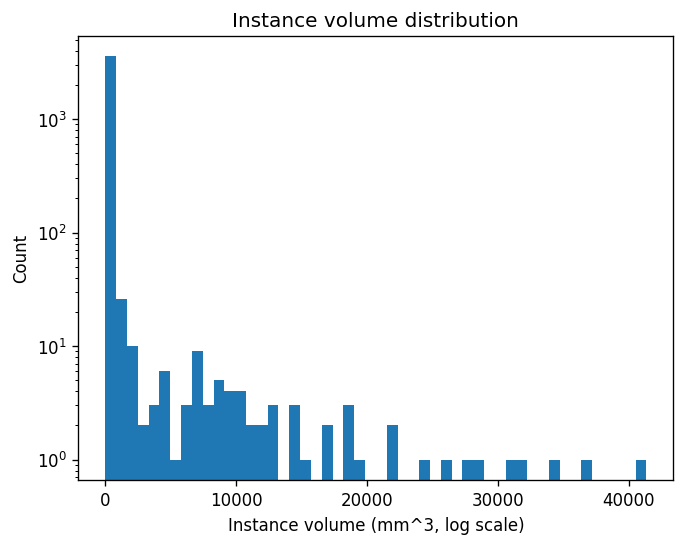

In [71]:
plt.figure()
plt.hist(instances_df["instance_volume"], bins=50)
plt.yscale('log')  # Log scale to see tiny lesions
plt.xlabel("Instance volume (mm^3, log scale)")
plt.ylabel("Count")
plt.title("Instance volume distribution")
plt.show()

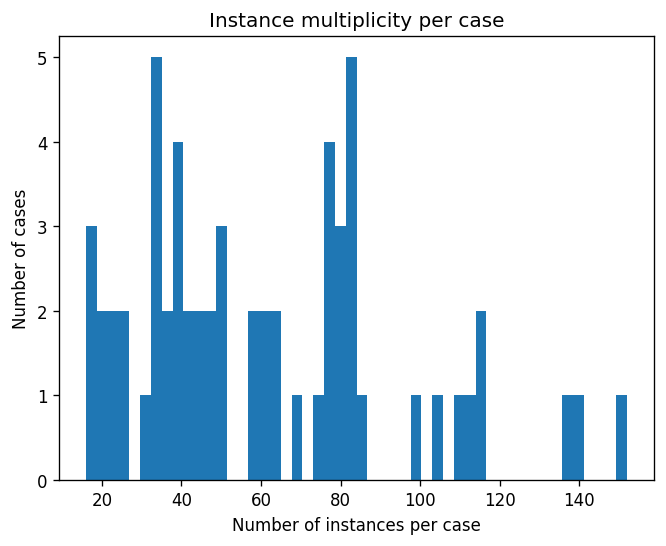

In [72]:
plt.figure()
plt.hist(cases_df["n_instances"], bins=50)
plt.xlabel("Number of instances per case")
plt.ylabel("Number of cases")
plt.title("Instance multiplicity per case")
plt.show()

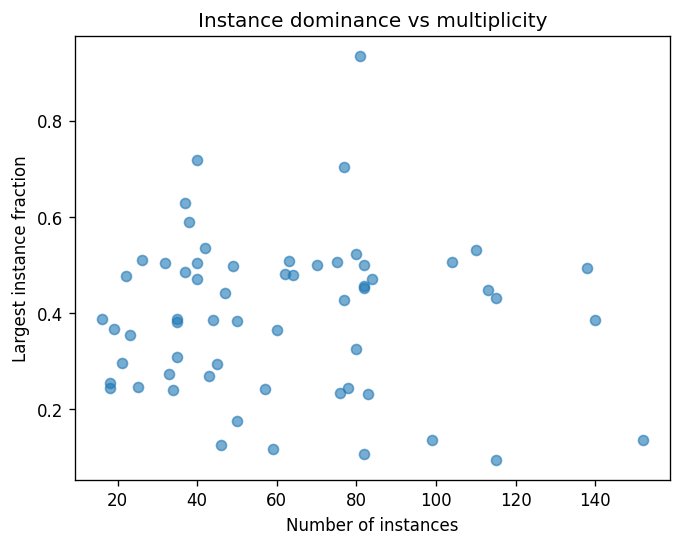

In [73]:
plt.figure()
plt.scatter(
    cases_df["n_instances"],
    cases_df["largest_fraction"],
    alpha=0.6
)
plt.xlabel("Number of instances")
plt.ylabel("Largest instance fraction")
plt.title("Instance dominance vs multiplicity")
plt.show()

In [75]:
OUTPUT_DIR = Path(f"{DATASET_DIR}/metrics")
OUTPUT_DIR.mkdir(exist_ok=True)

cases_df.drop(columns=["instance_volumes_mm3"]).to_csv(
    OUTPUT_DIR / "cases_metrics.csv", index=False
)
instances_df.to_csv(
    OUTPUT_DIR / "instances_metrics.csv", index=False
)
summary_df.to_csv(
    OUTPUT_DIR / "dataset_summary.csv"
)

print(f"Metrics exported to {OUTPUT_DIR}.")

Metrics exported to /home/student/sebastian_ma/Learning-to-Look-Closer/data/nnUNet_raw/Dataset601_WMH/metrics.
